In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  


In [15]:
#Remove Punctations
from string import punctuation



In [16]:
data = pd.read_csv('concatenated_df.csv')
#shuffle the data
data = data.sample(frac=1).reset_index(drop=True)
data.head() 

,content,suicidal,data_type,sentiment
0,Go get `em! lol,0,random_posts,neutral
1,If I die now I can end a failed strand of huma...,1,suicidal suicidal,NaN
2,I am an alcoholic incel that is about to kill ...,1,suicidal suicidal,NaN
3,Since part of your job is predicting what wil...,0,random_posts,neutral
4,Assignment actually looking pretty decent....s...,0,random_posts,positive


In [17]:
#lowercase
data['content'] = data['content'].apply(lambda x: x.lower()) 
#You can get this function from our discussion session code. However, we leave it as a blank for a practice.
def remove_punctuation(document):

    no_punct = ''.join([character for character in document if character not in punctuation])

    return no_punct

data['content'] = data['content'].apply(lambda x: remove_punctuation(x))

#####DIGITS######

def remove_digit(document):

    no_digit = ''.join([character for character in document if not character.isdigit()])

    return no_digit

data['content'] = data['content'].apply(lambda x: remove_digit(x))

#####TOKENIZATION######

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

data['content'] = data['content'].apply(lambda x: word_tokenize(x))

#####STOPWORDS######

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(document):

    words = [word for word in document if word not in stop_words]

    return words

data['content'] = data['content'].apply(lambda x: remove_stopwords(x))


#####STEMMING######

from nltk.stem import PorterStemmer

porter = PorterStemmer()

def stemmer(document):

    stemmed_document = [porter.stem(word) for word in document]

    return stemmed_document

data['content'] = data['content'].apply(lambda x: stemmer(x))




[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulfaverjon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulfaverjon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
data.drop(columns= ['sentiment'], inplace = True)
data.head()

,content,suicidal,data_type
0,"[go, get, em, lol]",0,random_posts
1,"[die, end, fail, strand, human]",1,suicidal suicidal
2,"[alcohol, incel, kill, life, meaningless]",1,suicidal suicidal
3,"[sinc, part, job, predict, happen, golf, cours...",0,random_posts
4,"[assign, actual, look, pretti, decentso, glad,...",0,random_posts


In [19]:
"""#sample the data to get as many negative as positive
len_pos = len(data[data['suicidal'] == 1])
len_neg = len(data[data['suicidal'] == 0])
print(len_pos, len_neg)

data_neg = data[data['suicidal'] == 0].sample(n=len_pos)

data = pd.concat([data[data['suicidal'] == 1], data_neg])
data = data.sample(frac=1).reset_index(drop=True)"""


"#sample the data to get as many negative as positive\nlen_pos = len(data[data['suicidal'] == 1])\nlen_neg = len(data[data['suicidal'] == 0])\nprint(len_pos, len_neg)\n\ndata_neg = data[data['suicidal'] == 0].sample(n=len_pos)\n\ndata = pd.concat([data[data['suicidal'] == 1], data_neg])\ndata = data.sample(frac=1).reset_index(drop=True)"

In [20]:
#Merge Three text column into one column and detokenize

from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
data_train_, data_test_ = train_test_split(data, test_size=0.2)

data_train = data_train_['content'].apply(TreebankWordDetokenizer().detokenize)
data_test = data_test_['content'].apply(TreebankWordDetokenizer().detokenize)

#Todo: Define your own CountVectorizer here, with min_df=0.005
countvec = CountVectorizer( min_df=0.002, max_df = 0.04 ) #,
sparse_dtm_train = countvec.fit_transform(data_train)
sparse_dtm_test = countvec.transform(data_test)
sparse_dtm_train

<8968x625 sparse matrix of type '<class 'numpy.int64'>'
	with 36628 stored elements in Compressed Sparse Row format>

In [21]:
dtm_train = pd.DataFrame(sparse_dtm_train.toarray(), columns=countvec.get_feature_names_out())
dtm_test = pd.DataFrame(sparse_dtm_test.toarray(), columns=countvec.get_feature_names_out())

In [22]:
print(dtm_train.shape)
dtm_test.head()


(8968, 625)


,abl,absolut,abus,access,account,actual,ad,add,afraid,ago,...,wunderlist,ya,yall,yay,ye,yeah,year,yesterday,yet,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


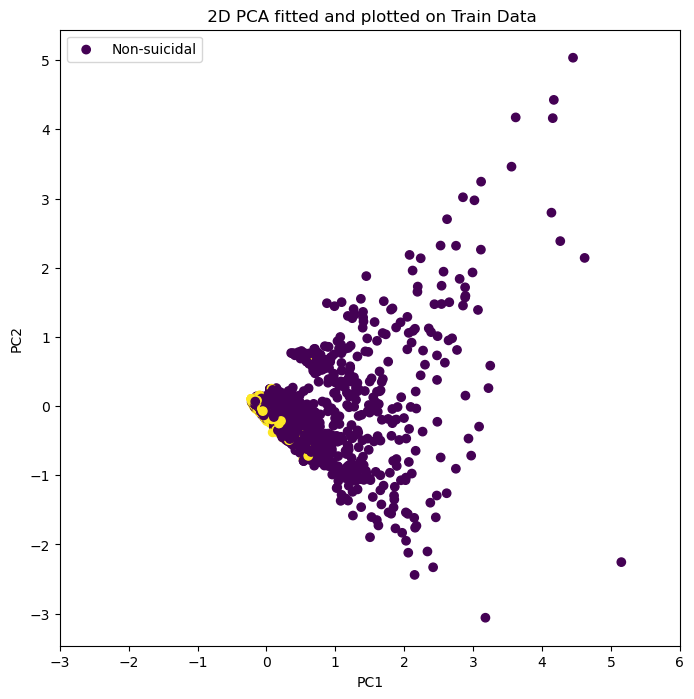

In [23]:
#do PCA on train data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(dtm_train)

#plot the PCA
plt.figure(figsize=(8,8))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c=data_train_['suicidal'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-3, 6)
plt.legend(['Non-suicidal', 'Suicidal'])
plt.title(' 2D PCA fitted and plotted on Train Data')
plt.show()


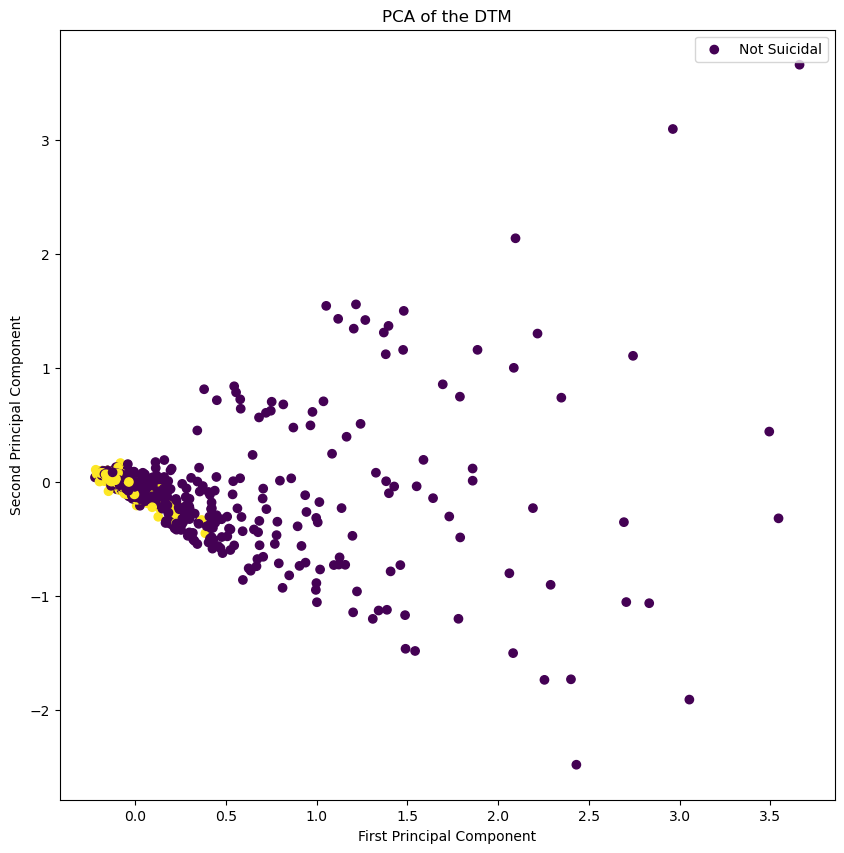

In [24]:
#now same thing for the test data
plt.figure(figsize=(10, 10))
plt.scatter(pca.transform(dtm_test)[:, 0], pca.transform(dtm_test)[:, 1], c=data_test_['suicidal'])
plt.legend(['Not Suicidal', 'Suicidal'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of the DTM')
plt.show()


In [25]:
#now in 3D with plotly
import plotly.express as px
pca = PCA(n_components=3)
pca.fit(dtm_train)
dtm_train_pca = pca.transform(dtm_train)
dtm_train_pca = pd.DataFrame(dtm_train_pca, columns=['PC1', 'PC2', 'PC3'])
dtm_train_pca['suicidal'] = data_train_['suicidal'].values
fig = px.scatter_3d(dtm_train_pca, x='PC1', y='PC2', z='PC3', color='suicidal')
fig.show()


In [26]:
#Becaues the 3D PCA works well, we are going to use it to do some prediction on the test data with kNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

pca = PCA(n_components=2)
dtm_train_pca = pca.fit_transform(dtm_train)
dtm_test_pca = pca.transform(dtm_test)

for n_neighbors in [1, 3, 5, 10, 20, 50]:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(dtm_train_pca, data_train_['suicidal'])
    predictions = knn.predict(dtm_test_pca)
    print('n_neighbors:', n_neighbors)
    FNR = np.sum((predictions == 0) & (data_test_['suicidal'] == 1)) / np.sum(data_test_['suicidal'] == 1)
    precision = np.sum((predictions == 1) & (data_test_['suicidal'] == 1)) / np.sum(predictions == 1)
    print('FNR:', FNR)
    print('precision:', precision)
    print('---------------------------------------------------')



n_neighbors: 1
FNR: 0.5435356200527705
precision: 0.5095729013254786
---------------------------------------------------
n_neighbors: 3
FNR: 0.5646437994722955
precision: 0.5892857142857143
---------------------------------------------------
n_neighbors: 5
FNR: 0.5488126649076517
precision: 0.5368916797488226
---------------------------------------------------
n_neighbors: 10
FNR: 0.5883905013192612
precision: 0.7446300715990454
---------------------------------------------------
n_neighbors: 20
FNR: 0.5923482849604221
precision: 0.7573529411764706
---------------------------------------------------
n_neighbors: 50
FNR: 0.6094986807387863
precision: 0.7708333333333334
---------------------------------------------------


n_neighbors: 20
FNR: 0.5934640522875817
precision: 0.7530266343825666


